# Cluster tiles

# table of content
1) [Classification results](#classification-results)
2) [Load samples](#load-samples)
3) [Compute features](#compute-features)
4) [Cluster through AHC](#cluster-through-ahc)
6) [Sort and visualize samples of each group](#sort-and-visualize-samples-of-each-group)
5) [Extract N highest number of singles](#extract-the-n-samples-with-highest-number-of-singles)

### Dependencies and general utils

In [18]:
# pip install scipy

In [19]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import open3d as o3d
import laspy
# import pdal
import json
import scipy
import copy
import pickle
from tqdm import tqdm
from scipy.spatial import cKDTree
from scipy.interpolate import griddata

### Classification results

                         tile_name  garbage  multi  single
0   color_grp_full_tile_92_out.laz       35      1       2
1  color_grp_full_tile_664_out.laz       84      4      12
2  color_grp_full_tile_637_out.laz       80      0       0
3  color_grp_full_tile_671_out.laz       30      2       6
4  color_grp_full_tile_657_out.laz       29      5      12
----
Number of tiles:  701
----
Average number of singles per tile:  46
----
Average number of the 701 tiles with the most single samples:  46
----


<Axes: >

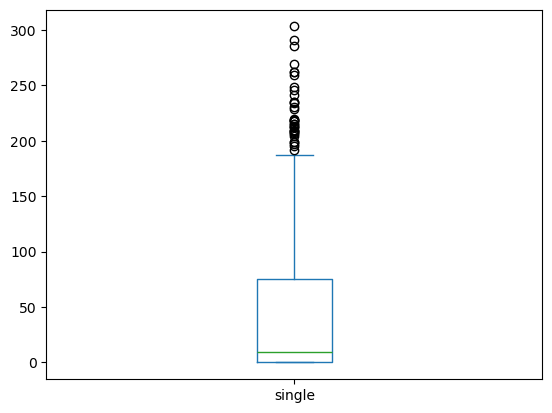

In [20]:
src_class_file = r"D:\PDM_repo\Github\PDM\data\full_dataset\selection\distribution_per_tile.csv"
df_class_results = pd.read_csv(src_class_file, sep=';')

# number of top samples to choose
num_top_samples = 0 # 0 to take everything


if num_top_samples == 0:
    num_top_samples = len(df_class_results)

print(df_class_results.head())
print('----')
print("Number of tiles: ", len(df_class_results))
print('----')
print("Average number of singles per tile: ", int(df_class_results.single.aggregate('mean')))
print('----')
df_top_samples = df_class_results.sort_values('single', ascending=False).iloc[0:num_top_samples]
print(f"Average number of the {num_top_samples} tiles with the most single samples: ", int(np.mean(df_top_samples.single.values)))
print('----')
# df_class_results.plot(kind='box', y='single')
df_top_samples.single.plot(kind='box')

### Load samples

In [21]:
src_tiles = r"D:\PDM_repo\Github\PDM\data\full_dataset\all_tiles\dataset_full_100m"
lst_selected_by_classification = [x.split('_out')[0] for x in df_top_samples.tile_name.values]
lst_files = [x for x in os.listdir(src_tiles) if x.split('.')[0] in lst_selected_by_classification]
print(lst_files)
print(list(lst_selected_by_classification))
print(len(lst_files))
print(len(lst_selected_by_classification))


['color_grp_full_tile_1.laz', 'color_grp_full_tile_10.laz', 'color_grp_full_tile_100.laz', 'color_grp_full_tile_101.laz', 'color_grp_full_tile_102.laz', 'color_grp_full_tile_103.laz', 'color_grp_full_tile_104.laz', 'color_grp_full_tile_105.laz', 'color_grp_full_tile_106.laz', 'color_grp_full_tile_107.laz', 'color_grp_full_tile_108.laz', 'color_grp_full_tile_109.laz', 'color_grp_full_tile_11.laz', 'color_grp_full_tile_110.laz', 'color_grp_full_tile_111.laz', 'color_grp_full_tile_112.laz', 'color_grp_full_tile_113.laz', 'color_grp_full_tile_114.laz', 'color_grp_full_tile_115.laz', 'color_grp_full_tile_116.laz', 'color_grp_full_tile_117.laz', 'color_grp_full_tile_118.laz', 'color_grp_full_tile_119.laz', 'color_grp_full_tile_120.laz', 'color_grp_full_tile_121.laz', 'color_grp_full_tile_122.laz', 'color_grp_full_tile_123.laz', 'color_grp_full_tile_124.laz', 'color_grp_full_tile_125.laz', 'color_grp_full_tile_126.laz', 'color_grp_full_tile_127.laz', 'color_grp_full_tile_128.laz', 'color_grp_

### Compute features

In [22]:
# utils
def remove_duplicates(laz_file):
    # Find pairs of points
    coords = np.round(np.vstack((laz_file.x, laz_file.y, laz_file.z)),2).T
    tree_B = cKDTree(coords)
    pairs = tree_B.query_pairs(1e-2)

    # Create the mask with dupplicates
    mask = [True for i in range(len(coords))]
    for pair in pairs:
        mask[pair[1]] = False

    # Remove the dupplicates from the file
    laz_file.points = laz_file.points[mask]


def flatten(laz, verbose=False):
    if verbose:
        print("Flattening...")
    
    remove_duplicates(laz)
    
    # laz.write(tile_src)
    points = np.vstack((laz.x, laz.y, laz.z)).T
    # print(list(laz.point_format.dimension_names))
    # print(points.shape)


    grid_size=10
    # Divide into tiles and find local minimums
    #   _Create grid and find min Z in each cell
    x_min, y_min = np.min(points[:, :2], axis=0)
    x_max, y_max = np.max(points[:, :2], axis=0)

    x_bins = np.append(np.arange(x_min, x_max, grid_size), x_max)
    y_bins = np.append(np.arange(y_min, y_max, grid_size), y_max)

    grid = {i:{j:[] for j in range(y_bins.size - 1)} for i in range(x_bins.size -1)}
    for _, (px, py, pz) in tqdm(enumerate(points), total=len(points), disable=~verbose):
        xbin = np.clip(0, (px - x_min) // grid_size, x_bins.size - 1)
        ybin = np.clip(0, (py - y_min) // grid_size, y_bins.size - 1)
        grid[xbin][ybin].append((px, py, pz))


    # Create grid_min
    grid_used = np.zeros((x_bins.size - 1, y_bins.size - 1))
    lst_grid_min = []
    lst_grid_min_pos = []
    for x in grid.keys():
        for y in grid[x].keys():
            if np.array(grid[x][y]).shape[0] > 0:
                grid_used[x, y] = 1
                # print(np.argmin(np.array(grid[x][y])[:,2]))
                lst_grid_min.append(np.min(np.array(grid[x][y])[:,2]))
                arg_min = np.argmin(np.array(grid[x][y])[:,2])
                lst_grid_min_pos.append(np.array(grid[x][y])[arg_min,0:2])
            else:
                grid_used[x, y] = 0
    # print(grid_used)
    arr_grid_min_pos = np.vstack(lst_grid_min_pos)
    
    # test if enough cells:
    if arr_grid_min_pos.shape[0] <= 4:
        raise ValueError("Tile is too small for the process.")

    # Interpolate
    points_xy = np.array(points)[:,0:2]
    interpolated_min_z = scipy.interpolate.griddata(arr_grid_min_pos, np.array(lst_grid_min), points_xy, method="cubic", fill_value=-1)

    mask_valid = np.array([x != -1 for x in list(interpolated_min_z)])
    points = points[mask_valid]
    points[:, 2] = interpolated_min_z[mask_valid]

    # Create floor
    filtered_points = {dim: getattr(laz, dim)[mask_valid] for dim in laz.point_format.dimension_names}
    header = laspy.LasHeader(point_format=laz.header.point_format, version=laz.header.version)
    floor = laspy.LasData(header)

    #   _assign filtered and modified data
    for dim, values in filtered_points.items():
        setattr(floor, dim, values)
    setattr(floor, 'x', points[:,0])
    setattr(floor, 'y', points[:,1])
    setattr(floor, 'z', points[:,2])

    # Create chm
    header = laspy.LasHeader(point_format=laz.header.point_format, version=laz.header.version)
    chm = laspy.LasData(header)

    #   _assign filtered and modified data
    for dim, values in filtered_points.items():
        setattr(chm, dim, values)
    setattr(chm, 'x', points[:,0])
    setattr(chm, 'y', points[:,1])
    setattr(chm, 'z', getattr(laz, 'z')[mask_valid] - points[:,2])

    # floor.write(os.path.join(src_res, f'floor_{suffixe}.laz'))
    # chm.write(os.path.join(src_res, f'chm_{suffixe}.laz'))
    return floor, chm

def compute_height_map_from_3d(in_point_cloud, resolution=1.0, verbose=False):
    if verbose:
        print("Computing height map...")
    # las = laspy.read(in_point_cloud)
    points = in_point_cloud.points
    if verbose:
        print("Number of points in tile: ", len(points))
    # print(points.X)
    x, y, z = points.X, points.Y, points.Z
    # x, y, z = in_point_cloud.x, in_point_cloud.y, in_point_cloud.z
    
    # Create regular grid
    xi = np.arange(x.min(), x.max(), resolution)
    yi = np.arange(y.min(), y.max(), resolution)
    xi, yi = np.meshgrid(xi, yi)
    
    # Interpolate Z values onto grid
    zi = griddata((x, y), z, (xi, yi), method='linear')

    return zi


def compute_gradient(in_height_map, resolution=1.0, verbose=False):
    if verbose:
        print("Computing gradient...")
        # Compute gradients
    dz_dx, dz_dy = np.gradient(in_height_map, resolution)
    slope_rad = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))
    # print(slope_rad.shape)
    # print(np.nanstd(slope_rad))
    # quit()
    x_slope_deg = np.degrees(dz_dx)
    y_slope_deg = np.degrees(dz_dy)
    slope_deg = np.degrees(slope_rad)

    # Return average slope (excluding NaNs)
    return np.nanmean(x_slope_deg), np.nanmean(y_slope_deg), np.nanmean(slope_deg), np.nanstd(slope_rad)

def compute_elevation(point_cloud,verbose=False):
    points = point_cloud.points
    mean_z = np.nanmean(points.Z)
    std_z = np.nanstd(points.Z)
    min_z = np.nanmin(points.Z)
    max_z = np.nanmax(points.Z)
    range_z = max_z - min_z
    return mean_z, std_z, min_z, max_z, range_z

def compute_vegetation(chm, tile_size=100, cell_size=10, verbose=False):
    height_vals = getattr(chm, 'z')
    max_height = np.nanmax(height_vals)   # Max vegetation height
    mean_height = np.nanmean(height_vals) # Mean height of non-ground points
    p95_height = np.nanpercentile(height_vals, 95)   # 95th percentile height
    cover_fraction = len(height_vals[height_vals > 2.0]) / len(height_vals) # Points above 2m / total
    lower_layer_density = len(height_vals[(height_vals >= 2.0) & (height_vals < 5.0)]) / len(height_vals) # 	Points in 2–5m layer
    mid_layer_density = len(height_vals[(height_vals >= 5.0) & (height_vals < 15.0)]) / len(height_vals)  # Points in 5–15m layer
    high_layer_density = len(height_vals[height_vals >= 15.0]) / len(height_vals)   # 	Points in >15m layer

    # rugosity
        # Filter points that are likely vegetation
    veg_mask = height_vals > 2.0
    x_veg = getattr(chm, 'x')[veg_mask] - np.min(getattr(chm, 'x'))
    y_veg = getattr(chm, 'y')[veg_mask] - np.min(getattr(chm, 'y'))
    z_veg = height_vals[veg_mask]

    # Divide the tile into sub-cells
    n_cells = int(tile_size / cell_size)
    max_heights = []
    for i in range(n_cells):
        for j in range(n_cells):
            x_min = i * cell_size
            x_max = (i + 1) * cell_size
            y_min = j * cell_size
            y_max = (j + 1) * cell_size

            # Extract points in the current sub-cell
            in_cell = (x_veg >= x_min) & (x_veg < x_max) & (y_veg >= y_min) & (y_veg < y_max)
            if np.any(in_cell):
                max_z = np.max(z_veg[in_cell])
                max_heights.append(max_z)
    rugosity = np.std(max_heights) if len(max_heights) > 0 else 0.0

    return max_height, mean_height, p95_height, cover_fraction, lower_layer_density, mid_layer_density, high_layer_density, rugosity

def normalize_data(data):
    return data

In [23]:
#for test
src_dest = r"D:\PDM_repo\Github\PDM\data\full_dataset\selection"
# src_temp = r"D:\PDM_repo\Github\PDM\data\full_dataset\temp"
# os.makedirs(src_temp, exist_ok=True)

do_process = False
do_elevation = False
do_gradient = False
do_vegetation = True

if do_process:
    lst_files_temp = lst_files[1:3]
    verbose=False
    resolution=10

    lst_gradients = []
    lst_elevation = []
    lst_vegetation = []
    for _, tile in tqdm(enumerate(lst_files), total=len(lst_files), desc="Processing"):
        # load sample
        laz = laspy.read(os.path.join(src_tiles, tile))

        if do_gradient or do_vegetation:
            try:
                floor, chm = flatten(laz, verbose=verbose)
            except Exception as e:
                print(f"Error on tile {tile}: {e}")
                continue
            # floor.write(os.path.join(src_temp, f"floor_{_}.laz"))
            # chm.write(os.path.join(src_temp, f"chm_{_}.laz"))

        # compute the gradient
        if do_gradient:
            height_map = compute_height_map_from_3d(floor, resolution=resolution, verbose=verbose)
            x_grad, y_grad, grad, std_grad = compute_gradient(height_map, resolution=resolution, verbose=verbose)

            # add the gradient to the list
            lst_gradients.append((tile, x_grad, y_grad, grad, std_grad))

        # compute elevation
        if do_elevation:
            mean_z, std_z, min_z, max_z, range_z = compute_elevation(laz)

            # add elevation to the list
            lst_elevation.append((tile, mean_z, std_z, min_z, max_z, range_z))

        # compute vegetation
        if do_vegetation:
            max_height, mean_height, p95_height, cover_fraction, lower_layer_density, mid_layer_density, high_layer_density, rugosity = compute_vegetation(chm, verbose=verbose)

            # add elevation to the list
            lst_vegetation.append((tile, max_height, mean_height, p95_height, cover_fraction, lower_layer_density, mid_layer_density, high_layer_density, rugosity))
            
    # save gradient
    if do_gradient:
        df_gradients = pd.DataFrame(lst_gradients, columns=["tile_name","x_grad", "y_grad", "grad", "std_grad"])
        df_gradients.to_csv(os.path.join(src_dest, "gradients.csv"), sep=';', index=False)
        print("Gradient saved to :", os.path.join(src_dest, "gradients.csv"))

    # save elevation
    if do_elevation:
        df_elevation = pd.DataFrame(lst_elevation, columns=["tile_name","mean_z", "std_z", "min_z", "max_z", "range_z"])
        df_elevation.to_csv(os.path.join(src_dest, "elevation.csv"), sep=';', index=False)
        print("Elevation saved to :", os.path.join(src_dest, "elevation.csv"))

    # save vegetation
    if do_vegetation:
        df_vegetation = pd.DataFrame(lst_vegetation, columns=[ "tile_name", "max_height", "mean_height", "p95_height", "cover_fraction", "lower_layer_density", "mid_layer_density", "high_layer_density", "rugosity"])
        df_vegetation.to_csv(os.path.join(src_dest, "vegetation.csv"), sep=';', index=False)
        print("Vegetation saved to :", os.path.join(src_dest, "vegetation.csv"))
else:
    df_gradients = pd.read_csv(os.path.join(src_dest, "gradients.csv"), sep=';')
    df_elevation = pd.read_csv(os.path.join(src_dest, "elevation.csv"), sep=';')
    df_vegetation = pd.read_csv(os.path.join(src_dest, "vegetation.csv"), sep=';')

    print(df_gradients.head())
    print(df_elevation.head())
    print(df_vegetation.head())


                     tile_name     x_grad     y_grad       grad  std_grad
0    color_grp_full_tile_1.laz -14.742035   1.480083  15.537607  0.077067
1   color_grp_full_tile_10.laz -21.077549   5.926579  21.149968  0.028314
2  color_grp_full_tile_100.laz -89.887805  -1.588987  57.253121  0.138940
3  color_grp_full_tile_101.laz -26.524842  18.724936  30.438387  0.056222
4  color_grp_full_tile_102.laz -60.298679  -4.611439  48.175282  0.209754
                     tile_name         mean_z        std_z   min_z   max_z  \
0    color_grp_full_tile_1.laz  216555.913840   762.430300  215139  218293   
1   color_grp_full_tile_10.laz  223823.514481  1109.743164  221616  226264   
2  color_grp_full_tile_100.laz  206552.672013  4391.410051  197415  215882   
3  color_grp_full_tile_101.laz  197731.040016  1712.796307  193782  203347   
4  color_grp_full_tile_102.laz  205881.171650  3517.065518  197415  215131   

   range_z  
0     3154  
1     4648  
2    18467  
3     9565  
4    17716  
         

### Cluster through AHC

In [24]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Example DataFrame
df_class_results.tile_name = [''.join(x.split('_out')) for x in df_class_results.tile_name.values]
df = pd.merge(left=df_class_results, right=df_gradients, on='tile_name')
df = pd.merge(left=df, right=df_elevation, on='tile_name')
df = pd.merge(left=df, right=df_vegetation, on='tile_name')

# Normalize the features
scaler = StandardScaler()
features = scaler.fit_transform(df.drop('tile_name', axis=1))


In [25]:
from sklearn.cluster import AgglomerativeClustering

# Choose the number of clusters (or explore using a dendrogram)
n_clusters = 4
clustering = AgglomerativeClustering(n_clusters=n_clusters)
df["cluster"] = clustering.fit_predict(features)


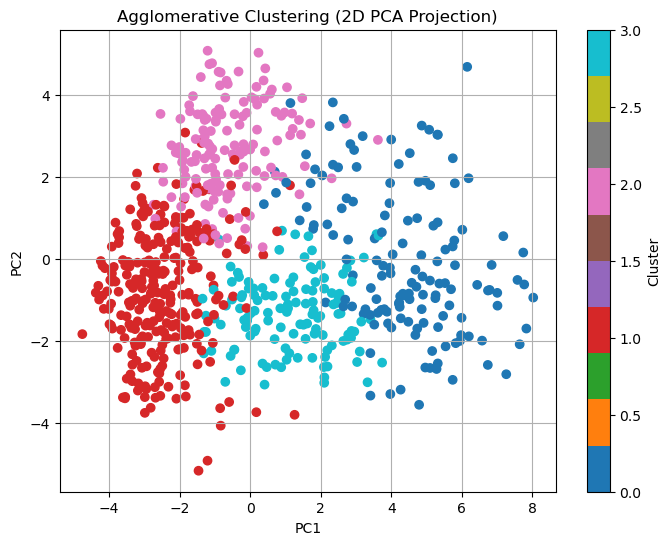

In [26]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=df["cluster"], cmap="tab10")
plt.title("Agglomerative Clustering (2D PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()


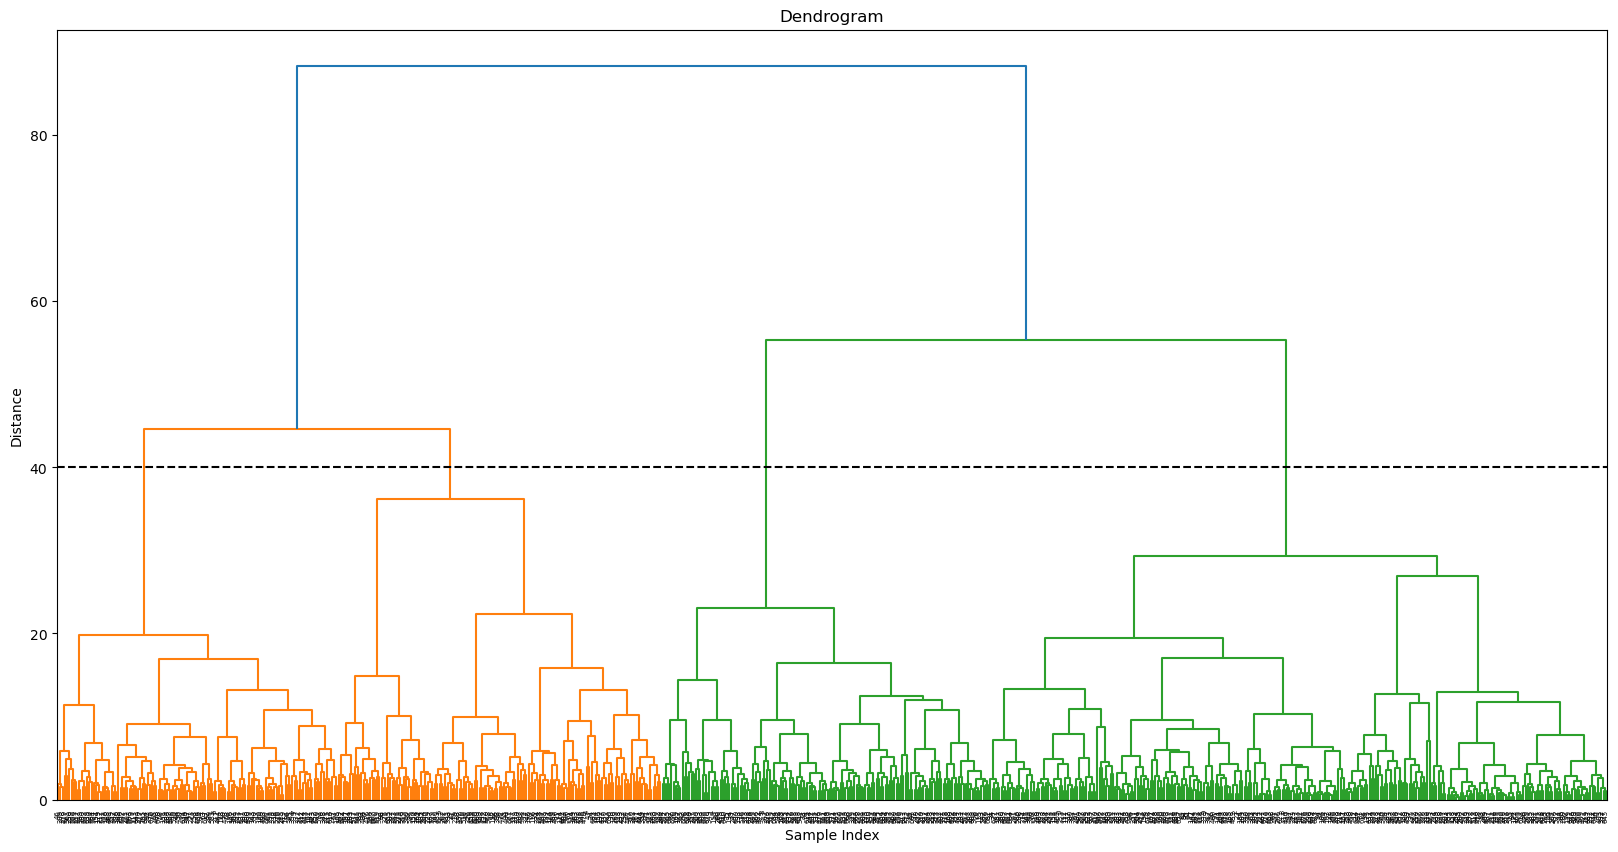

In [28]:
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(20, 10))
Z = sch.linkage(features, method="ward")
threshold = 40
dendrogram = sch.dendrogram(Z)
plt.axhline(y=threshold, color='black', linestyle='--')
plt.title("Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()


In [29]:
from scipy.cluster.hierarchy import fcluster

# `t` is your threshold — the height to cut the dendrogram
cluster_ids = fcluster(Z, t=threshold, criterion='distance')
df['cluster_id'] = cluster_ids
df.to_csv(os.path.join(src_dest, 'clustered.csv'), sep=';', index=False)


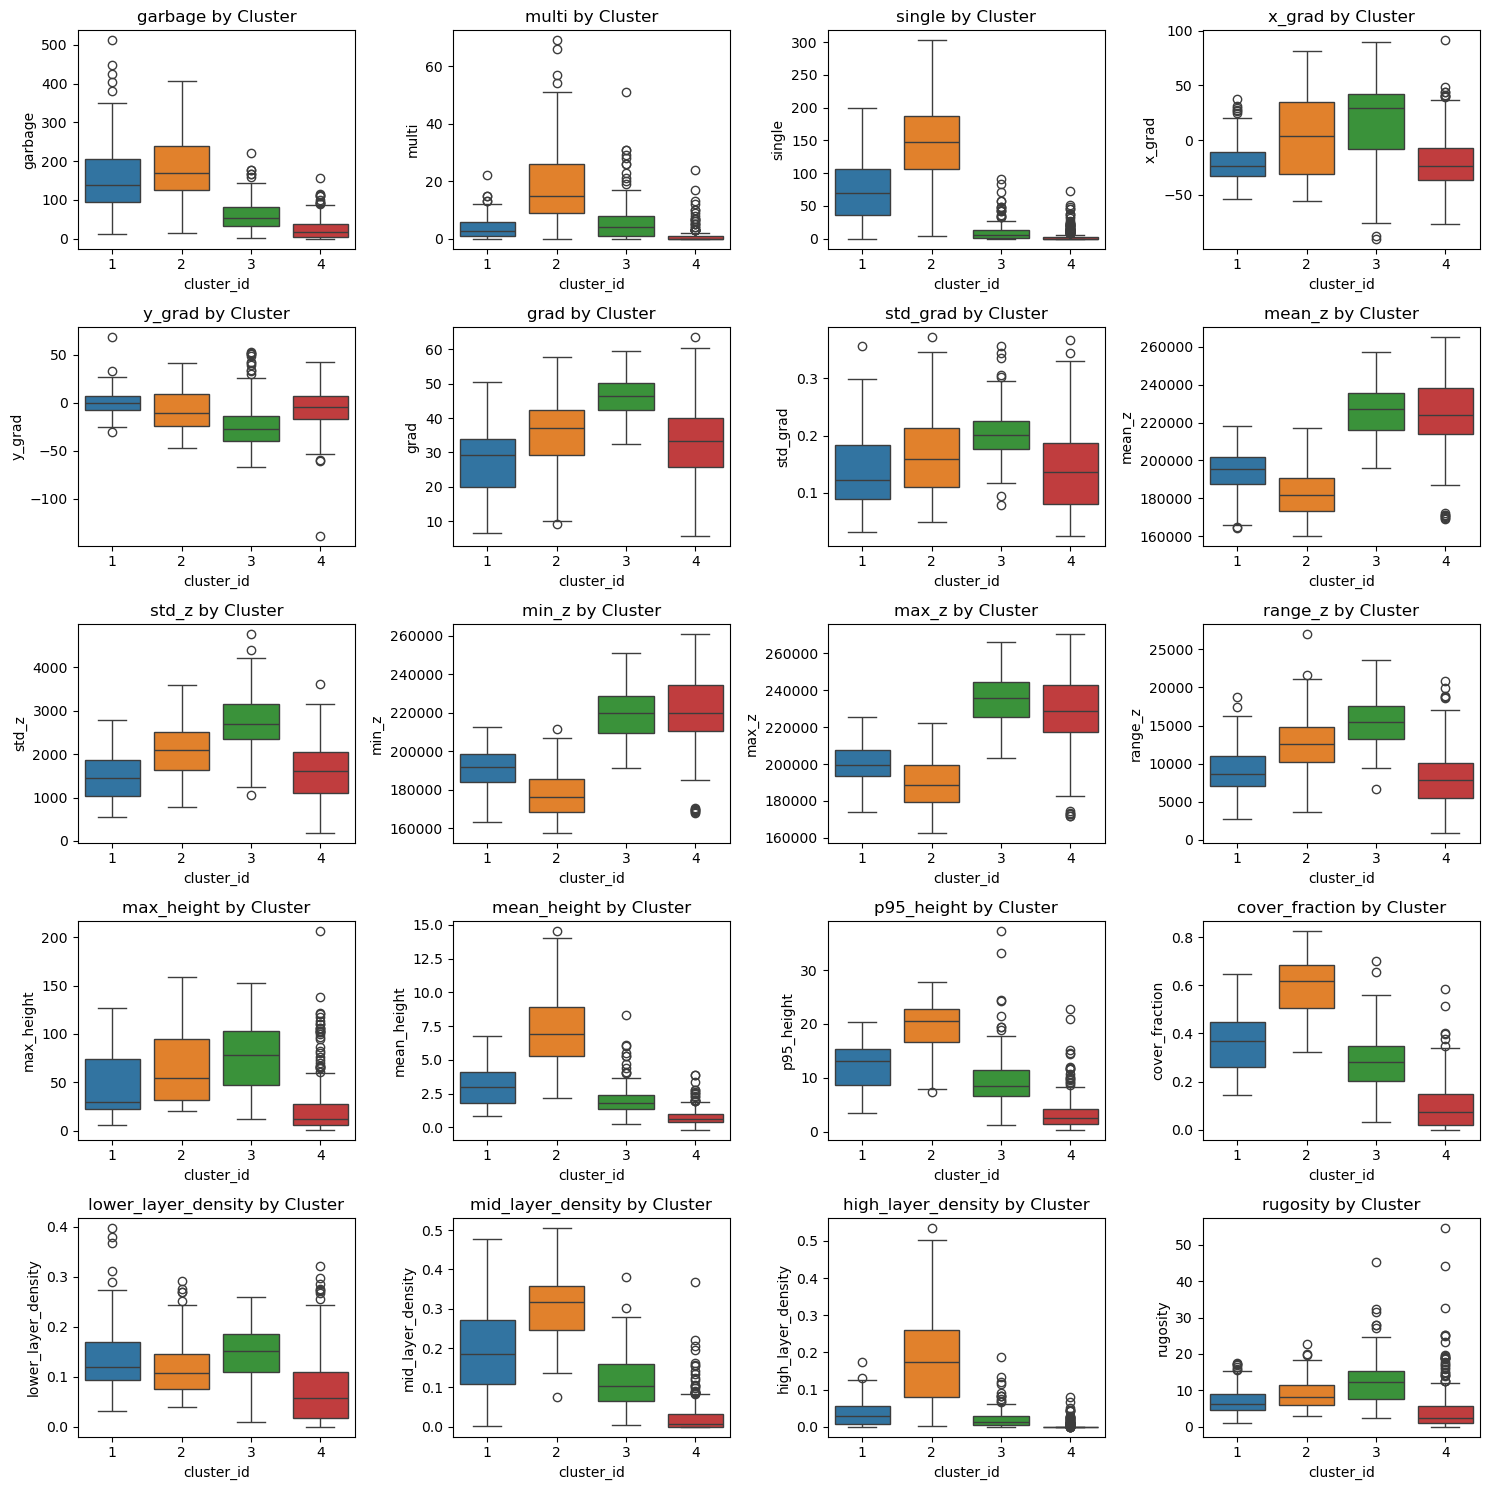

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

lst_features = list(df.columns)
for x in ['tile_name', 'cluster_id', 'cluster']:
    if x in lst_features:
        lst_features.remove(x)

num_rows = int(len(lst_features)**0.5)+1
num_cols = (len(lst_features)+1) // num_rows
fig, axis = plt.subplots(num_rows, num_cols, figsize=(15,15))
axis = axis.flatten()
for feature_id, feature in enumerate(lst_features):
    sns.boxplot(data=df, x='cluster_id', y=feature, hue='cluster_id', legend=False, palette='tab10', ax=axis[feature_id])
    axis[feature_id].set_title(f'{feature} by Cluster')
for ax_id in [x for x in range(len(axis)) if x >= len(lst_features)]:
    axis[ax_id].set_axis_off()
plt.tight_layout()
plt.show()

### Sort and visualize samples of each group

In [31]:
def load_laz(file_path):
    las = laspy.read(file_path)
    points = np.vstack((las.x, las.y, las.z)).transpose()  # Extract XYZ coordinates
    return points


def print_camera_info(vis):
    ctr = vis.get_view_control()

    saved_cam_params = ctr.convert_to_pinhole_camera_parameters()

    # Extract parameters
    intrinsic = saved_cam_params.intrinsic.intrinsic_matrix
    extrinsic = saved_cam_params.extrinsic
    fov = ctr.get_field_of_view()

    print("\nCamera Parameters:")
    print(f"Intrinsic Matrix:\n{intrinsic}")
    print(f"Extrinsic Matrix:\n{extrinsic}")
    print(f"Field of View: {fov} degrees\n")
    return False  # Do not block the visualization loop


def apply_camera_params(vis, extrinsic):
    ctr = vis.get_view_control()

    # Convert to Open3D format
    cam_params = ctr.convert_to_pinhole_camera_parameters()
    # cam_params.intrinsic.set_intrinsics(1280, 720, intrinsic[0][0], intrinsic[1][1], intrinsic[0][2], intrinsic[1][2])
    cam_params.extrinsic = np.array(extrinsic)

    # Apply settings
    ctr.convert_from_pinhole_camera_parameters(cam_params, allow_arbitrary=True)

    return False


def visualize_laz(file_path, mode='normal', display_mode='3d', extrinsic=None, image_dest_src=None, gt=False):
    # Load point cloud
    # pcd = o3d.io.read_point_cloud(file_path)  # Replace with your file

    # assert not semantic == instance == True
    assert mode in ['normal', 'instance', 'semantic']
    assert display_mode in ['3d', 'image']

    laz = laspy.read(file_path)
    points = load_laz(file_path)
 
    if mode == 'semantic':
        cat = getattr(laz, 'PredSemantic') if gt == False else getattr(laz, 'gt_semantic_segmentation')
        colors = np.zeros((cat.size, 3))
        colors[np.arange(cat.size), cat] = 1

    if mode == 'instance':
        # list of colors
        list_colors = [
            (1.00, 0.00, 0.00), (0.00, 1.00, 0.00), (0.00, 0.00, 1.00), (1.00, 1.00, 0.00), (1.00, 0.00, 1.00),
            (0.00, 1.00, 1.00), (0.50, 0.00, 0.00), (0.50, 0.50, 0.00), (0.00, 0.50, 0.00), (0.50, 0.00, 0.50),
            (0.00, 0.50, 0.50), (0.00, 0.00, 0.50), (1.00, 0.65, 0.00), (0.65, 0.16, 0.16), (0.54, 0.17, 0.89),
            (0.37, 0.62, 0.63), (0.50, 1.00, 0.00), (0.86, 0.08, 0.24), (1.00, 0.84, 0.00), (0.29, 0.00, 0.51)
        ]

        # cat = getattr(laz, 'PredInstance') if gt == False else getattr(laz, 'gt_instance_segmentation')
        cat = getattr(laz, 'PredInstance') if gt == False else np.array(getattr(laz, 'treeID'))
        print(cat)
        colors = np.zeros((cat.size, 3))
        for i in range(cat.size):
            colors[i, :] = list_colors[cat[i] % len(list_colors)]
        

    # Convert numpy array to Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    if mode in ['semantic', 'instance']:
        pcd.colors = o3d.utility.Vector3dVector(colors)
        
    # Create visualizer
    vis = o3d.visualization.VisualizerWithKeyCallback()
    vis.create_window()
    vis.add_geometry(pcd)

    if extrinsic:
        apply_camera_params(vis, extrinsic)

    if display_mode == '3d':
        # Assign 'C' key (67 in ASCII) to print camera vectors
        vis.register_key_callback(67, print_camera_info)  # Press 'C' to print vectors

        # Run visualization
        vis.run()
        vis.destroy_window()
    else:
        # 🔹 Step 3: Capture rendered image
        image = vis.capture_screen_float_buffer(do_render=True)  # Get image as a NumPy array
        vis.destroy_window()  # Close the visualizer

        # 🔹 Step 4: Convert and show image with Matplotlib
        image_np = np.asarray(image)  # Convert to NumPy array
        fig = plt.figure(figsize=(10,10))
        plt.imshow(image_np)
        plt.axis("off")  # Hide axes
        plt.show()
        if image_dest_src:
            plt.imsave(image_dest_src, image_np)

            
        # fig, axs = plt.subplots(2, 2, figsize=(10,10))
        # axs = axs.flatten()
        # axs[0].imshow(image_np)
        # image_np = np.rot90(image_np)
        # axs[1].imshow(image_np)
        # image_np = np.rot90(image_np)
        # axs[2].imshow(image_np)
        # image_np = np.rot90(image_np)
        # axs[3].imshow(image_np)
        # plt.axis("off")  # Hide axes
        # plt.show()
        # if image_dest_src:
        #     plt.imsave(image_dest_src, image_np)

In [32]:
clusters = sorted(df.cluster_id.unique())
num_samples_to_show = 10

src_clusters = r"D:\PDM_repo\Github\PDM\data\full_dataset\selection\clusters"
os.makedirs(src_clusters, exist_ok=True)

matrix = [
    [0.799004256, -0.562297342, 0.213105367, -1437610.28],
    [0.0222251102, -0.326535956, -0.944923443, 301431.209],
    [0.600914505, 0.759734144, -0.248406498, -2379796.27],
    [0.0, 0.0, 0.0, 1.0]
]
for cluster in clusters:
    df_cluster = df.loc[df.cluster_id == cluster]
    df_cluster = df_cluster.sample(n=min(num_samples_to_show, len(df_cluster)), random_state=42)
    tiles_src = df_cluster.tile_name.to_list()
    print(f"CLUSTER {cluster}:")
    print(tiles_src)
    src_cluster = os.path.join(src_clusters, f"cluster_{cluster}")
    os.makedirs(src_cluster)
    for tile in tiles_src:
        shutil.copyfile(
            os.path.join(src_tiles, tile),
            os.path.join(src_cluster, tile)
        )
    #     visualize_laz(os.path.join(src_tiles, tile), extrinsic=None, display_mode='image')

CLUSTER 1:
['color_grp_full_tile_129.laz', 'color_grp_full_tile_99.laz', 'color_grp_full_tile_251.laz', 'color_grp_full_tile_292.laz', 'color_grp_full_tile_340.laz', 'color_grp_full_tile_699.laz', 'color_grp_full_tile_316.laz', 'color_grp_full_tile_328.laz', 'color_grp_full_tile_255.laz', 'color_grp_full_tile_248.laz']
CLUSTER 2:
['color_grp_full_tile_512.laz', 'color_grp_full_tile_608.laz', 'color_grp_full_tile_509.laz', 'color_grp_full_tile_317.laz', 'color_grp_full_tile_541.laz', 'color_grp_full_tile_616.laz', 'color_grp_full_tile_571.laz', 'color_grp_full_tile_540.laz', 'color_grp_full_tile_604.laz', 'color_grp_full_tile_586.laz']
CLUSTER 3:
['color_grp_full_tile_93.laz', 'color_grp_full_tile_85.laz', 'color_grp_full_tile_63.laz', 'color_grp_full_tile_77.laz', 'color_grp_full_tile_667.laz', 'color_grp_full_tile_672.laz', 'color_grp_full_tile_563.laz', 'color_grp_full_tile_639.laz', 'color_grp_full_tile_427.laz', 'color_grp_full_tile_554.laz']
CLUSTER 4:
['color_grp_full_tile_10.laz

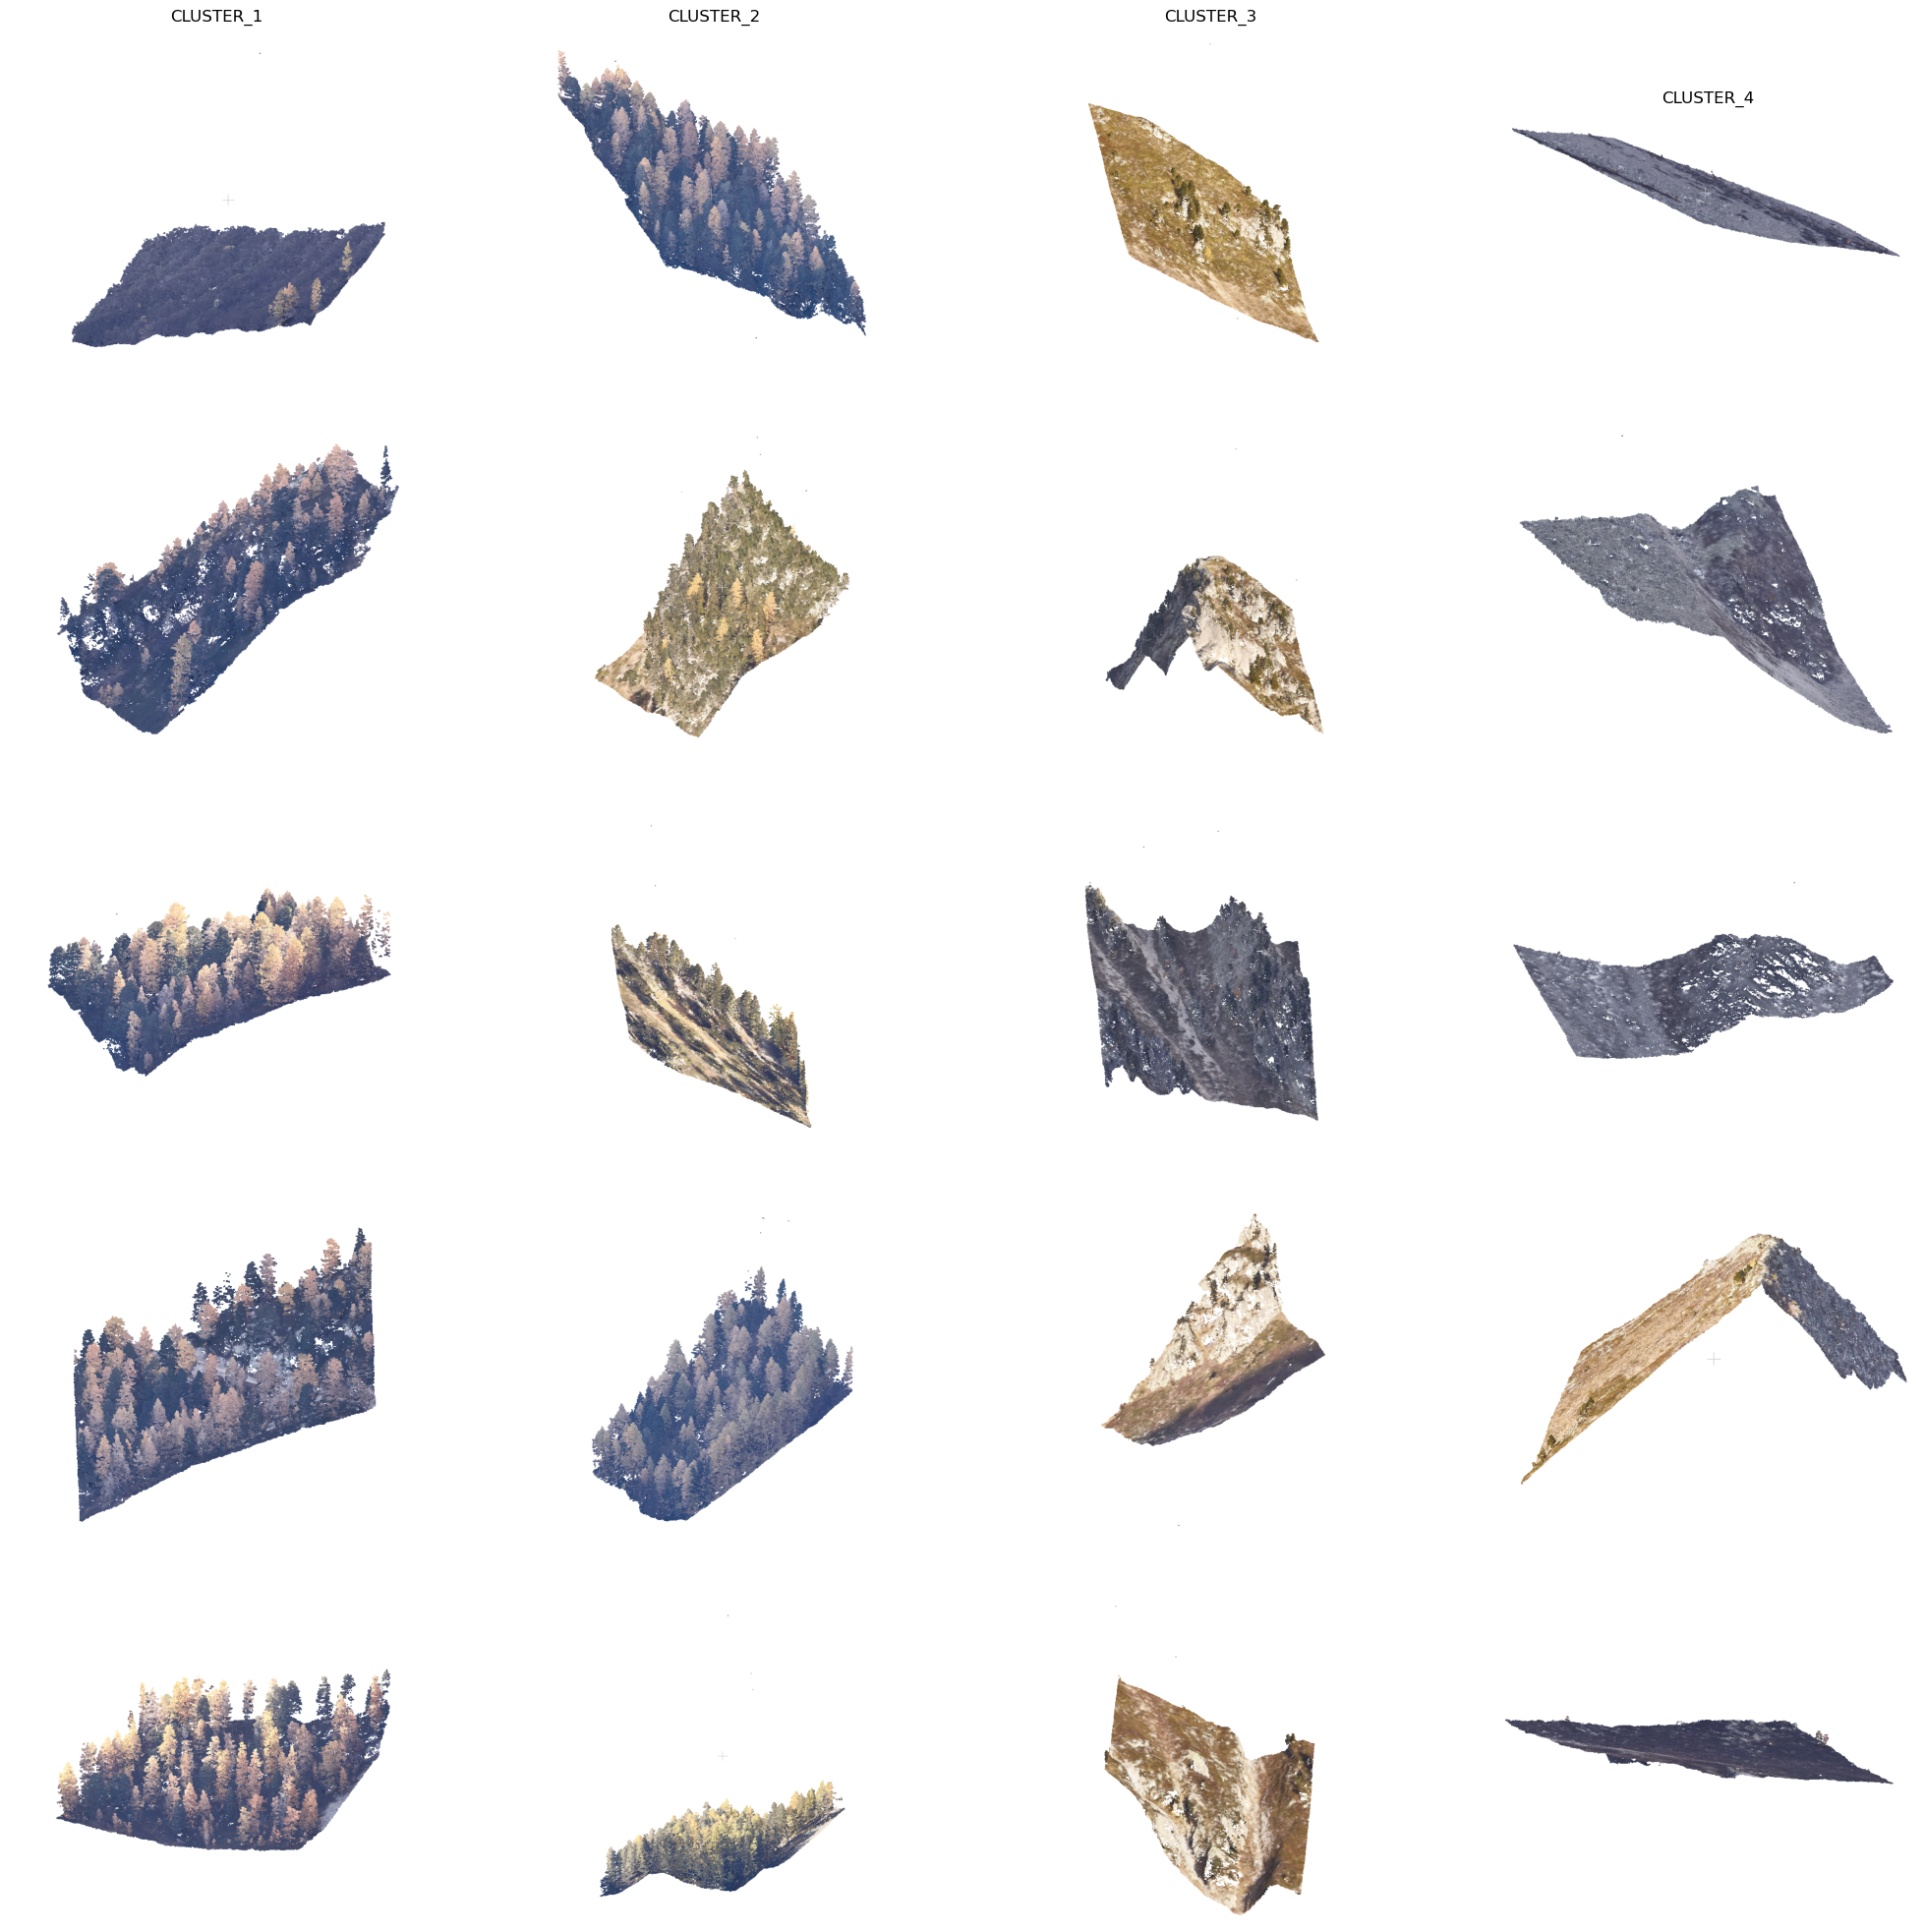

In [34]:
# Show subsamples
src_clusters = r"D:\PDM_repo\Github\PDM\data\full_dataset\selection\clusters"
num_clusters = 4
num_images_per_cluster = 5
fig, axs = plt.subplots(num_images_per_cluster, num_clusters, figsize=(25,25))
for num_col, cluster in enumerate(os.listdir(src_clusters)):
    lst_images = [x for x in os.listdir(os.path.join(src_clusters, cluster)) if x.endswith(('.png', '.jpg', '.bmp', 'jpeg'))]
    axs[0, num_col].set_title(cluster.upper())
    for num_row, image_src in enumerate(lst_images):
        image = plt.imread(os.path.join(src_clusters, cluster, image_src))
        axs[num_row, num_col].imshow(image)
        axs[num_row, num_col].set_axis_off()


### Extract the N samples with highest number of singles

In [8]:
src_class_file = r"D:\PDM_repo\Github\PDM\data\full_dataset\selection\distribution_per_tile.csv"
src_files = r"D:\PDM_repo\Github\PDM\data\full_dataset\all_tiles\dataset_full_100m"
src_dest = r"D:\PDM_repo\Github\PDM\data\full_dataset\selection\most_single_100"
df_class_results = pd.read_csv(src_class_file, sep=';')
df_class_results.tile_name = [''.join(x.split('_out')) for x in df_class_results.tile_name.values]

os.makedirs(src_dest, exist_ok=True)
# number of top samples to choose
num_top_samples = 100

df_top_samples_single = df_class_results.sort_values('single', ascending=False).iloc[0:num_top_samples]
print(f"Average number of the {num_top_samples} tiles with the most single samples: ", int(np.mean(df_top_samples_single.single.values)))
print('----')

for _, file in tqdm(enumerate(df_top_samples_single.tile_name.values), total=num_top_samples, desc="Copying files"):
    if not os.path.exists(os.path.join(src_files, file)):
        print("Could not find: ", os.path.join(src_files, file))
        continue
    shutil.copyfile(os.path.join(src_files, file), os.path.join(src_dest, file))

Average number of the 100 tiles with the most single samples:  183
----


Copying files: 100%|██████████| 100/100 [00:01<00:00, 95.53it/s]


In [4]:
src_class_file = r"D:\PDM_repo\Github\PDM\data\full_dataset\selection\distribution_per_tile.csv"
df_class_results = pd.read_csv(src_class_file, sep=';')
print(df_class_results.tile_name)

df_class_results.tile_name = [''.join(x.split('_out')) for x in df_class_results.tile_name.values]

print(df_class_results.tile_name)


0       color_grp_full_tile_92_out.laz
1      color_grp_full_tile_664_out.laz
2      color_grp_full_tile_637_out.laz
3      color_grp_full_tile_671_out.laz
4      color_grp_full_tile_657_out.laz
                    ...               
696    color_grp_full_tile_408_out.laz
697    color_grp_full_tile_173_out.laz
698    color_grp_full_tile_500_out.laz
699    color_grp_full_tile_170_out.laz
700    color_grp_full_tile_564_out.laz
Name: tile_name, Length: 701, dtype: object
0       color_grp_full_tile_92.laz
1      color_grp_full_tile_664.laz
2      color_grp_full_tile_637.laz
3      color_grp_full_tile_671.laz
4      color_grp_full_tile_657.laz
                  ...             
696    color_grp_full_tile_408.laz
697    color_grp_full_tile_173.laz
698    color_grp_full_tile_500.laz
699    color_grp_full_tile_170.laz
700    color_grp_full_tile_564.laz
Name: tile_name, Length: 701, dtype: object
